In [1]:
import torch
import umap
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from hubersed.style import *
from hubersed.paths import PATHS

DATA_PATH = PATHS['DATA']
RESULTS_PATH = PATHS['RESULTS']

Missing colon in file PosixPath('/Users/ng27753/Astronomy_Research/hubersed/styles/apj.mplstyle'), line 30 ('    \\usepackage{amsmath}')
Missing colon in file PosixPath('/Users/ng27753/Astronomy_Research/hubersed/styles/apj.mplstyle'), line 31 ('    \\usepackage{amssymb}')


In [83]:
device = torch.device('cpu')

In [84]:
latent_space_dict = torch.load(DATA_PATH / 'desi_noise_spender_10latent_space.pt', map_location=device)

In [85]:
latents = latent_space_dict['latents']

A = latent_space_dict['A']
A = A.squeeze()

z = latent_space_dict['zs']

In [86]:
reducer = umap.UMAP(random_state=14, n_neighbors=5).fit(latents)

/Users/ng27753/Astronomy_Research/hubersed/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [87]:
embeddings = reducer.transform(latents)

In [90]:
fig, ax = plt.subplots(1, 2, figsize=(7., 3.5), dpi=300)
ax = ax.ravel()

# both ax should be equal aspect
for a in ax:
    a.set_aspect('equal', 'box')

scatter = ax[0].scatter(
    embeddings[:, 0], embeddings[:, 1],
    c=z, cmap='viridis',
    s=0.005, alpha=0.7,
    rasterized=True,
    marker='.'
)

# colorbar on top
cbar = fig.colorbar(
    scatter,
    ax=ax[0],
    orientation='horizontal',
    pad=0.02,          # distance between plot and colorbar
    fraction=0.05,     # thickness of colorbar
    location='top',
)
# range of colorbar 0 to 0.6
cbar.set_label('z')


import matplotlib as mpl
norm = mpl.colors.LogNorm(vmin=1, vmax=1000)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap='viridis')
scatter.set_cmap(cmap.cmap)

scatter = ax[1].scatter(embeddings[:, 0], embeddings[:, 1], c=A, s=.005, alpha=0.7, norm=norm, rasterized=True, marker='.')

cbar = plt.colorbar(scatter, ax=ax[1], orientation='horizontal', pad=0.02, fraction=0.05, location='top')
cbar.set_label('A')

# fig.tight_layout()

# no ticks
for a in ax:
    a.set_xticks([])
    a.set_yticks([])

fig.savefig(RESULTS_PATH / 'desi_noise_spender_10latent_space_umap.pdf', dpi=300)


In [14]:
# do for spectra

spender_spec = torch.load(DATA_PATH / 'spender_spec_6latent')
s_l = spender_spec['latents'].to(device)

prospector_spec = torch.load(DATA_PATH / 'prospector_noise_spec_6latent')
p_l = prospector_spec['latents'].to(device)

In [22]:
reducer = umap.UMAP(n_neighbors=15).fit(p_l)

/Users/ng27753/Astronomy_Research/hubersed/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [23]:
s_e = reducer.transform(s_l)
p_e = reducer.transform(p_l)

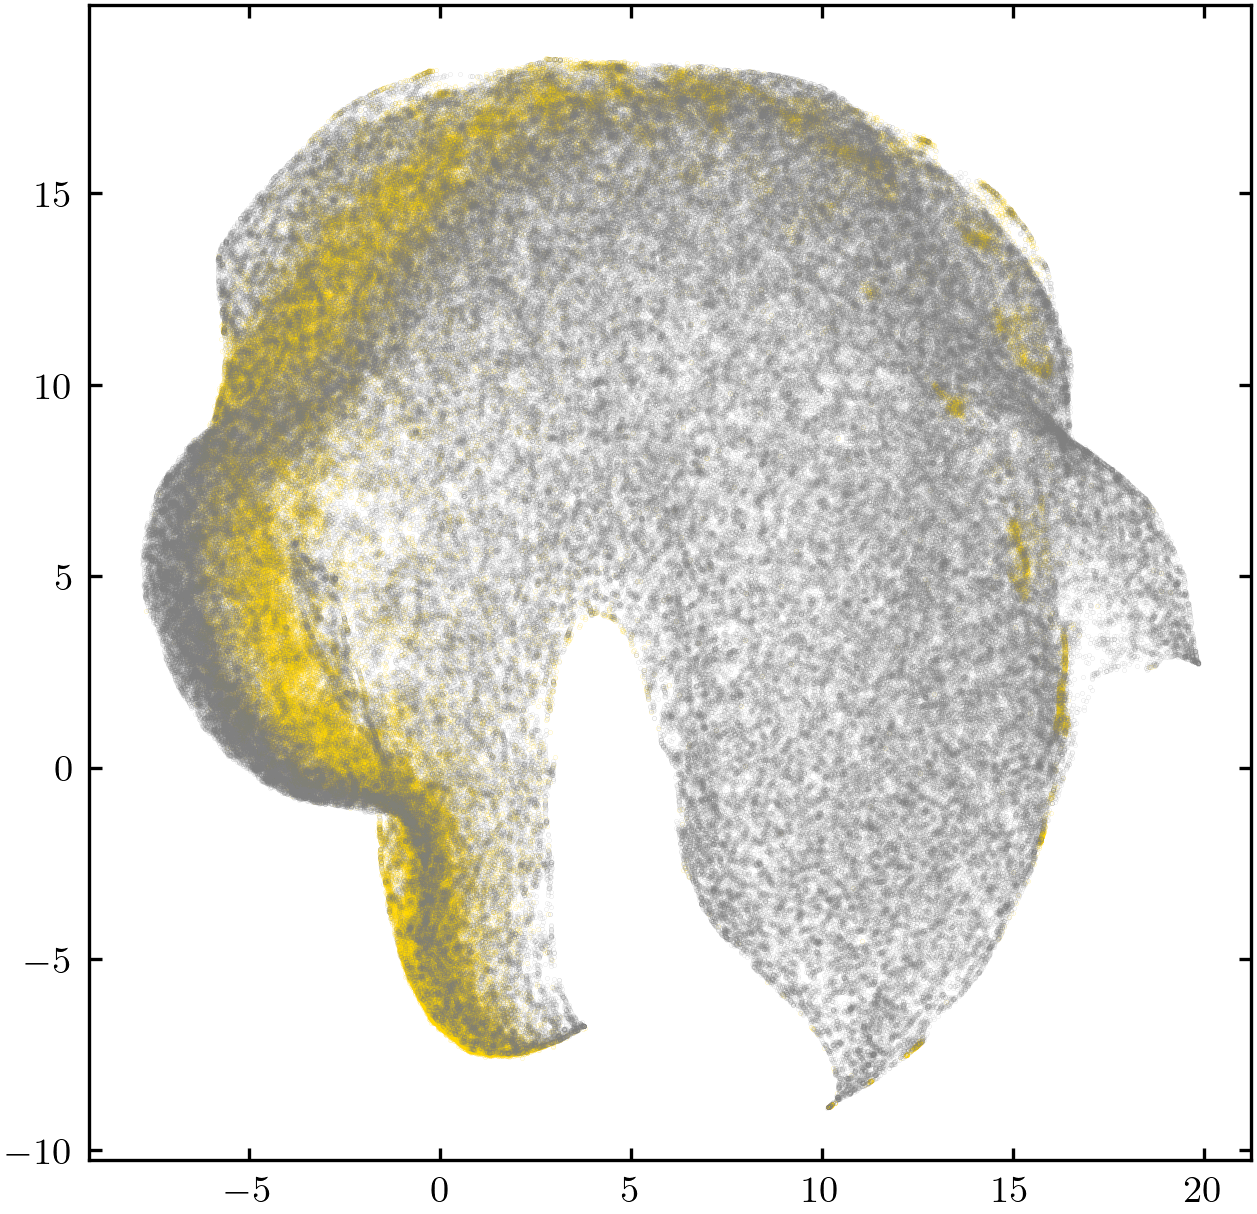

In [24]:
plt.figure(figsize=(5, 5), dpi=300)
plt.scatter(s_e[:, 0], s_e[:, 1], s=0.005, alpha=0.5, color='gold')
plt.scatter(p_e[:, 0], p_e[:, 1], s=0.0025, alpha=0.5, color='gray')

KeyboardInterrupt: 

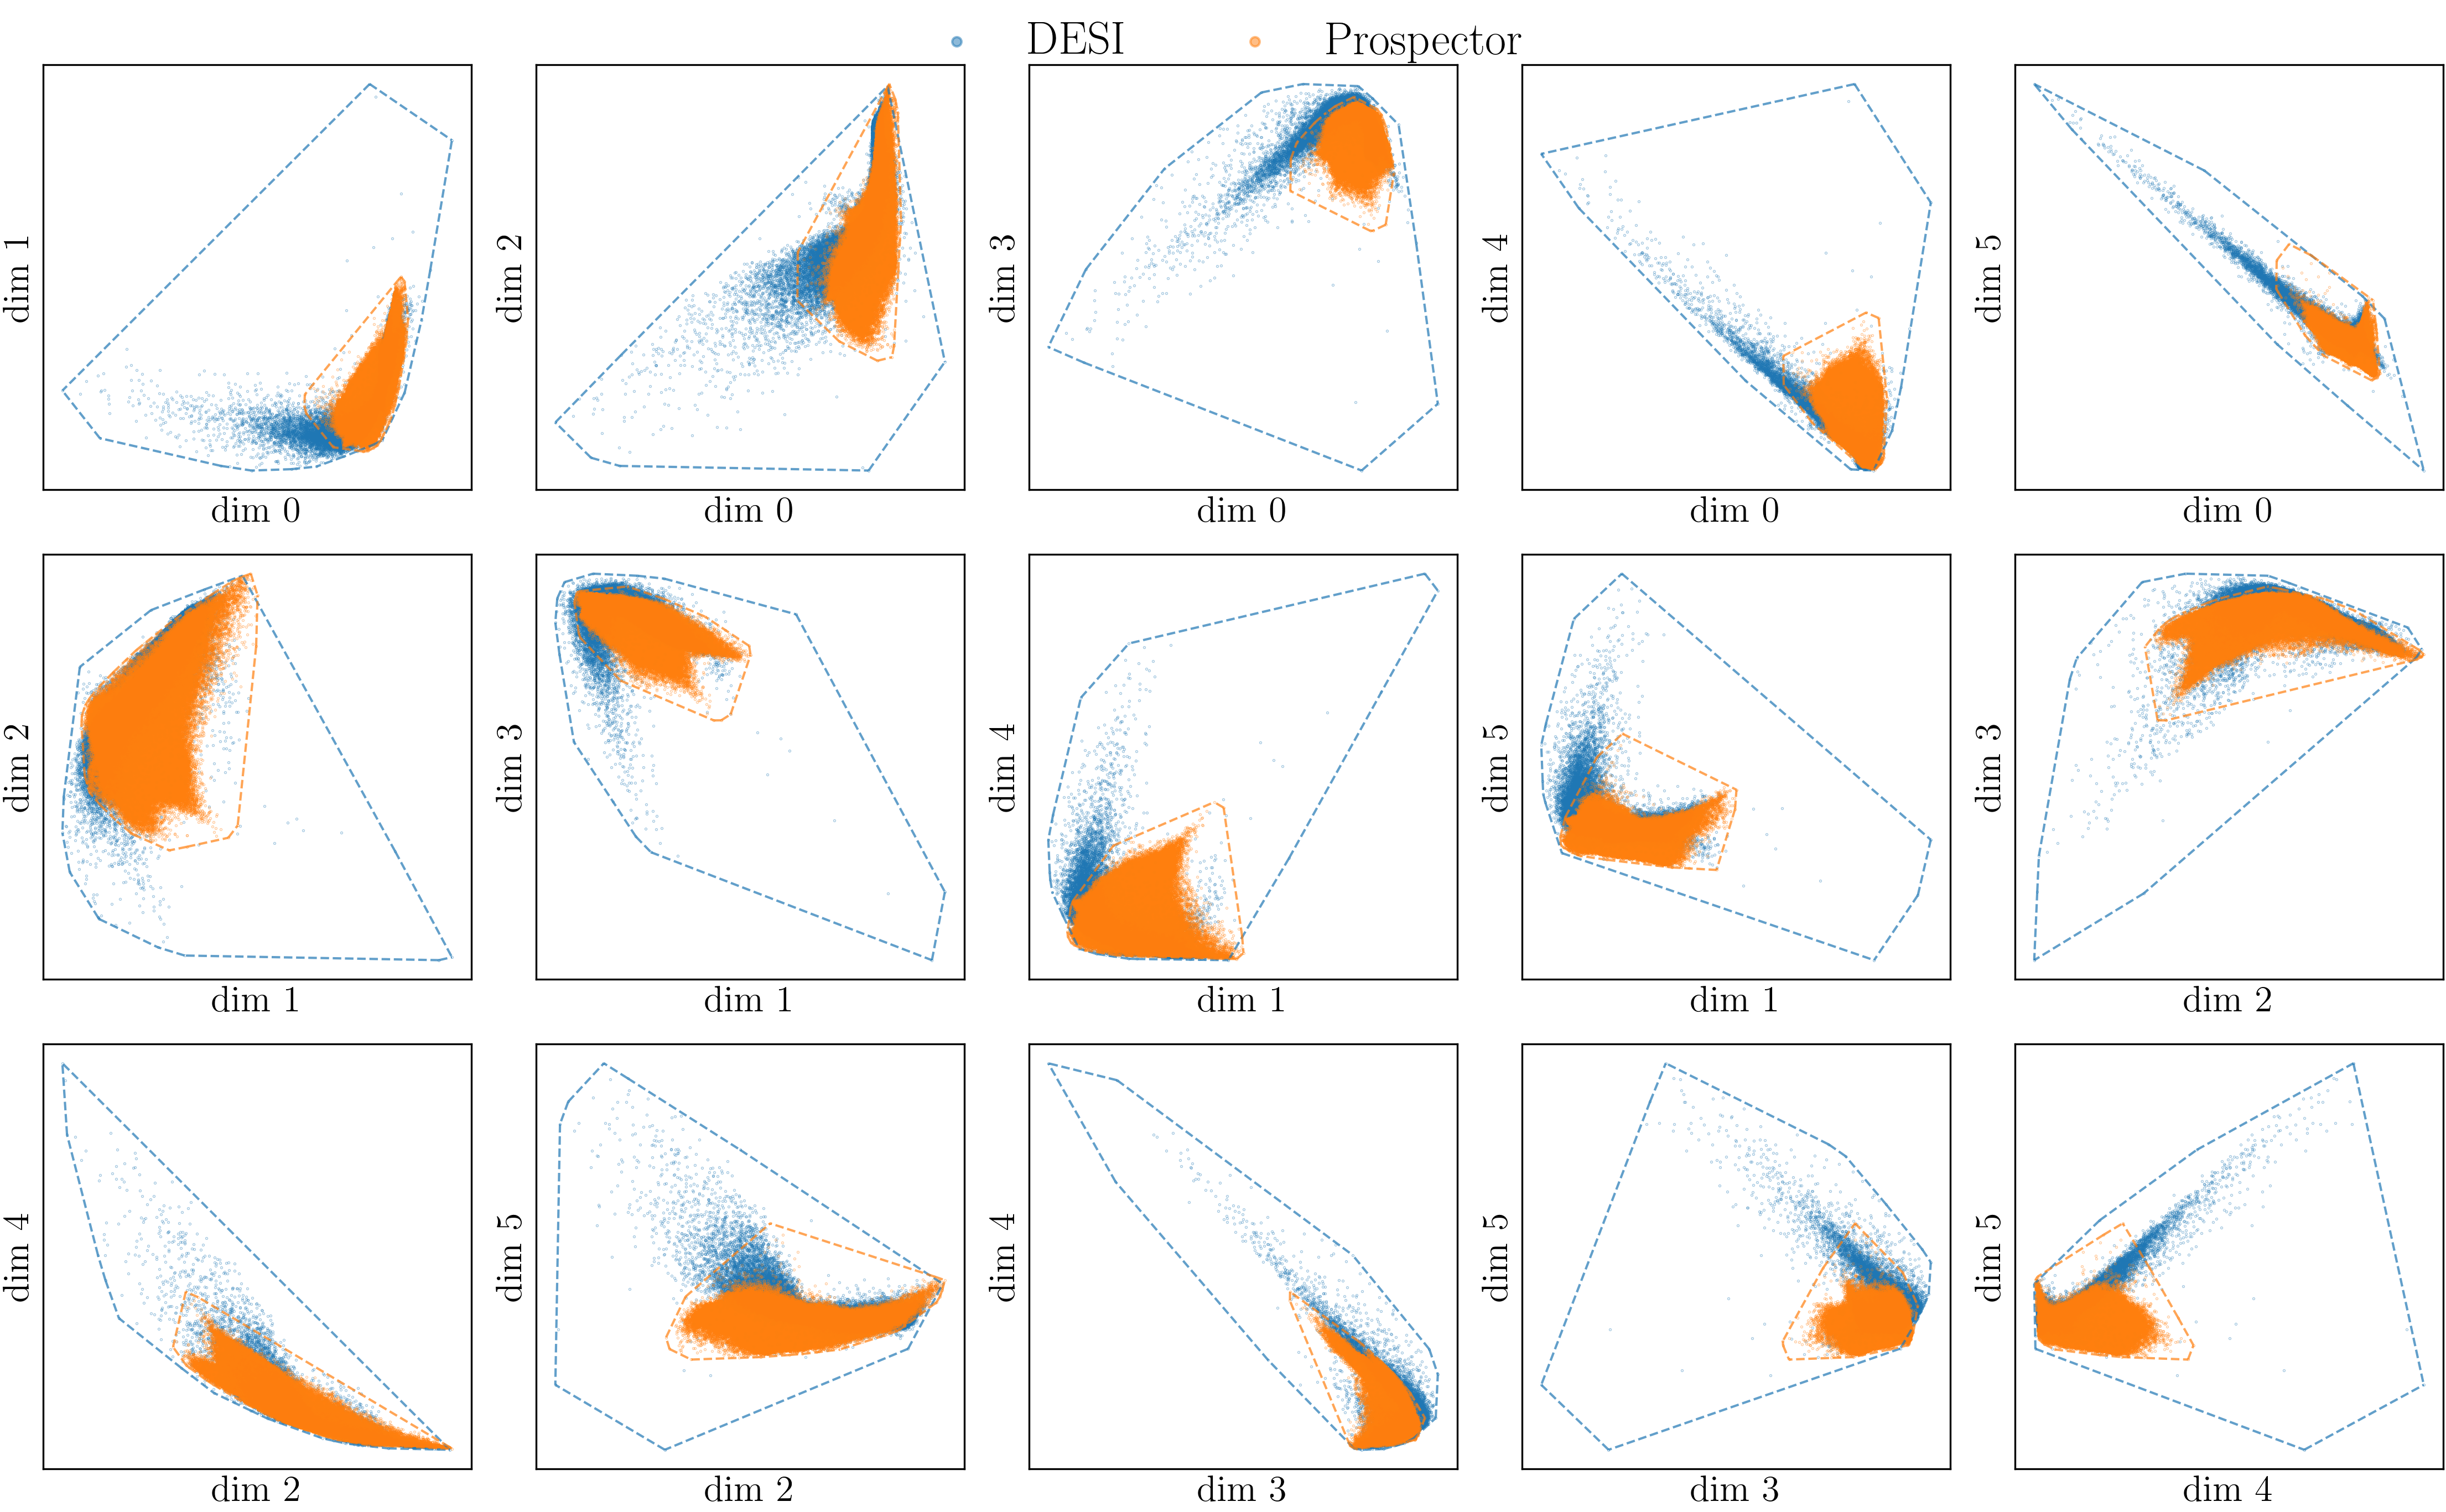

In [94]:
import itertools
# s_l: [N, 6]
N, D = s_l.shape

pairs = list(itertools.combinations(range(D), 2))  # [(0,1), (0,2), ..., (4,5)]
n_plots = len(pairs)

# choose grid size (e.g. 3 columns)
ncols = 5
nrows = int(np.ceil(n_plots / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))
axes = axes.ravel()

for ax, (i, j) in zip(axes, pairs):
    x_desi = s_l[:, i]
    y_desi = s_l[:, j]

    x_prospector = p_l[:, i]
    y_prospector = p_l[:, j]

    ax.scatter(x_desi.cpu(), y_desi.cpu(), s=0.05, alpha=0.5, label='DESI')
    ax.scatter(x_prospector.cpu(), y_prospector.cpu(), s=0.05, alpha=0.5, label='Prospector')

    from scipy.spatial import ConvexHull

    # DESI
    points_desi = np.vstack((x_desi.cpu(), y_desi.cpu())).T
    hull_desi = ConvexHull(points_desi, qhull_options='QG4')
    for simplex in hull_desi.simplices:
        ax.plot(points_desi[simplex, 0], points_desi[simplex, 1], 'C0--', alpha=0.7, label='DESI')
    
    # Prospector
    points_prospector = np.vstack((x_prospector.cpu(), y_prospector.cpu())).T
    hull_prospector = ConvexHull(points_prospector)
    for simplex in hull_prospector.simplices:
        ax.plot(points_prospector[simplex, 0], points_prospector[simplex, 1], 'C1--', alpha=0.7, label='Prospector')
    

    # ax.legend(markerscale=10, fontsize=12)
    ax.set_xlabel(f"dim {i}", fontsize=16)
    ax.set_ylabel(f"dim {j}", fontsize=16)
    # ax.set_title(f"Scatter of col {i} vs col {j}", )
    ax.set_xticks([])
    ax.set_yticks([])
    # break

fig.tight_layout()
fig.legend( ['DESI', 'Prospector'], loc='upper center', markerscale=18, fontsize=20, ncol=2, bbox_to_anchor=(0.5, 1.04))
fig.savefig(RESULTS_PATH / 'desi_prospector_6latent_pairwise_comparison.pdf', dpi=300)